<a href="https://colab.research.google.com/github/AaronTYT/IOD_capstone_GeoPPE_Sentinel/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:
## GeoPPE Sentinel: AI-Powered PPE & Fatigue Safety for WA MineSites

PPE pictures dataset (Roboflow/Kaggle):

APIs used for this project:
- API 1
- API 2

#### Make sure that your VS Code is connected to Google Colab
Need Google Colab for GPU to train CNN model test this before importing all the python libraries:

Ensure that the kernel you selected is from Google Colab and ensure you selected GPU (T4)

In [1]:
import tensorflow as tf
import torch

In [2]:

print(tf.config.list_physical_devices('GPU'))
print(torch.cuda.is_available())

[]
False


In [3]:
import sys

def is_running_in_colab():
    return 'google.colab' in sys.modules

print("Running in Google Colab?", is_running_in_colab())

Running in Google Colab? True


#### Import Python libraries here

In [4]:
# === Core scientific stack ===
import numpy as np
import pandas as pd
from scipy import stats

# === Plotting ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Utilities / IO ===
import requests
from IPython.display import display, clear_output

from sklearn.calibration import CalibratedClassifierCV

# === Scikit-learn ===
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector

# === Models packages ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# === Models packages (ensemble) ===
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# === Evaulation ML ===
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score,
    balanced_accuracy_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

import pickle, json, time, platform, sklearn

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

### Dataset sources
1. PPE Detection Dataset (Hardhat + Vest).
Construction PPE dataset — used as a baseline for mining PPE detection.
Resource: https://universe.roboflow.com/roboflow-universe-projects/personal-protective-equipment-combined-model/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true


2. Fatigue Detection Dataset
3. WA Mines Geospatial Dataset

In [5]:
from google.colab import drive

# Mount Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "/content/drive/MyDrive/PPE_Dataset"

'Personal Protective Equipment - Combined Model.v1i.yolov8.zip'


In [7]:
!unzip -qq "/content/drive/MyDrive/PPE_Dataset/Personal Protective Equipment - Combined Model.v1i.yolov8.zip" -d "/content/ppe"

In [8]:
!ls "ppe"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


## 📊 EDA of Datasets
Before building any models, it’s important to understand the structure, format, and quality of each dataset. EDA helps validate assumptions, identify data issues, and guide preprocessing decisions.

**Dataset 1 — PPE Images (CNN Model)**
- Image dataset used for training a Convolutional Neural Network.
- Contains labelled folders for PPE categories (e.g., helmet, vest, gloves, etc.).
- EDA focuses on:
  - Class distribution
  - Image sizes and shapes
  - File integrity
  - Visual inspection of sample images
  - Potential augmentation needs

**Dataset 2 — Fatigue Dataset (Tabular, CSV file format)**
Used to train either supervised or unsupervised models to either predict or perform clustering

## Dataset 1: PPE Images EDA
Checking to see if all the 3 folders match the number of images and the labels required for this project

In [9]:
import os

base_path = "/content/ppe"

splits = ["train", "valid", "test"]

# Count total images across all splits
total_images = sum(len(os.listdir(os.path.join(base_path, split, "images"))) for split in splits)

print(f"TOTAL IMAGES: {total_images}\n")

for split in splits:
    img_dir = os.path.join(base_path, split, "images")
    lbl_dir = os.path.join(base_path, split, "labels")

    num_imgs = len(os.listdir(img_dir))
    num_lbls = len(os.listdir(lbl_dir))

    pct = (num_imgs / total_images) * 100

    print(f"{split.upper():<6} → Images: {num_imgs:<6} Labels: {num_lbls:<6} ({pct:.2f}% of total)")


TOTAL IMAGES: 44002

TRAIN  → Images: 30765  Labels: 30765  (69.92% of total)
VALID  → Images: 8814   Labels: 8814   (20.03% of total)
TEST   → Images: 4423   Labels: 4423   (10.05% of total)


In [10]:
from pathlib import Path

for split in splits:
    img_dir = Path(base_path) / split / "images"
    lbl_dir = Path(base_path) / split / "labels"

    img_files = [f.stem for f in img_dir.glob("*.jpg")]
    lbl_files = [f.stem for f in lbl_dir.glob("*.txt")]

    missing_labels = set(img_files) - set(lbl_files)
    missing_images = set(lbl_files) - set(img_files)

    print(f"\n{split.upper()}:")
    print("Missing labels:", len(missing_labels))
    print("Missing images:", len(missing_images))



TRAIN:
Missing labels: 0
Missing images: 0

VALID:
Missing labels: 0
Missing images: 0

TEST:
Missing labels: 0
Missing images: 0


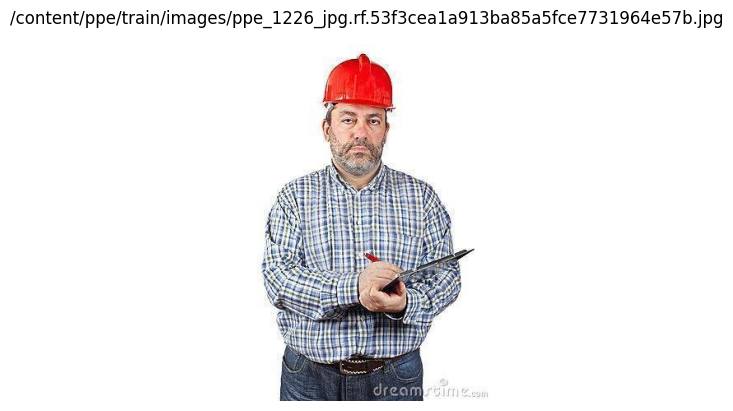

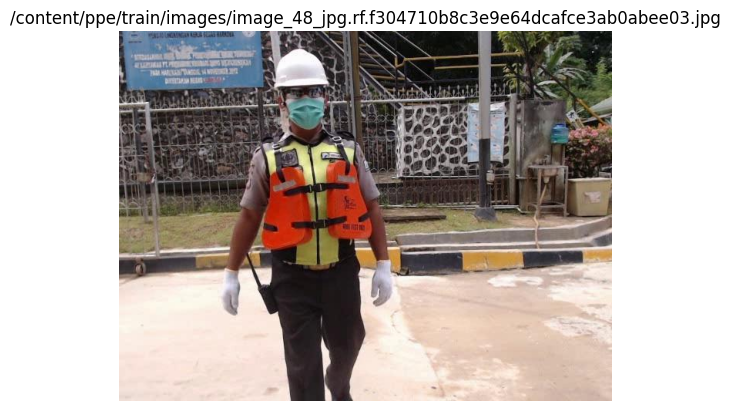

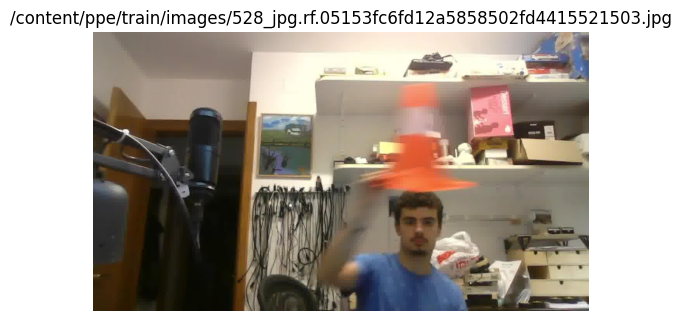

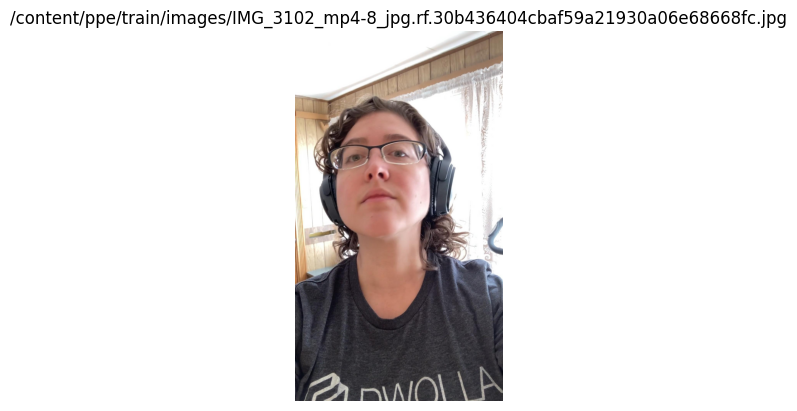

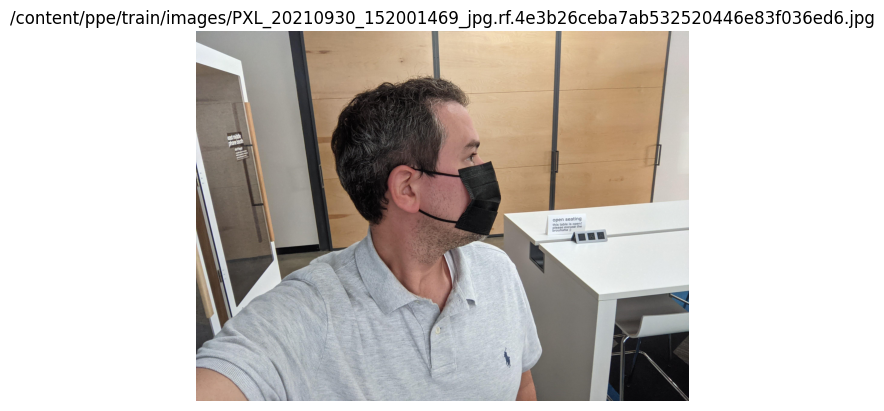

In [11]:
import cv2
import matplotlib.pyplot as plt
import glob

sample_imgs = glob.glob("/content/ppe/train/images/*.jpg")[:5]

for img_path in sample_imgs:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(img_path)
    plt.axis('off')
    plt.show()

In [12]:
import os
from glob import glob
import pandas as pd

base_path = "/content/ppe"
splits = ["train", "valid", "test"]

# Store results
results = {}

for split in splits:
    label_files = glob(f"{base_path}/{split}/labels/*.txt")

    class_counts = {}

    for lf in label_files:
        with open(lf, "r") as f:
            lines = f.readlines()
            for line in lines:
                cls = int(line.split()[0])
                class_counts[cls] = class_counts.get(cls, 0) + 1

    results[split] = class_counts

# --- Display ---
print("Class Counts Per Split:\n")
for split, counts in results.items():
    print(f"--- {split.upper()} ---")
    for cls, count in sorted(counts.items()):
        print(f"Class {cls}: {count}")
    print()


Class Counts Per Split:

--- TRAIN ---
Class 0: 3149
Class 1: 3381
Class 2: 2959
Class 3: 28996
Class 4: 734
Class 5: 1989
Class 6: 4280
Class 7: 2817
Class 8: 9706
Class 9: 1577
Class 10: 1436
Class 11: 1034
Class 12: 9845
Class 13: 4499

--- VALID ---
Class 0: 899
Class 1: 858
Class 2: 827
Class 3: 8952
Class 4: 202
Class 5: 554
Class 6: 1258
Class 7: 859
Class 8: 2222
Class 9: 505
Class 10: 362
Class 11: 277
Class 12: 3016
Class 13: 1287

--- TEST ---
Class 0: 450
Class 1: 430
Class 2: 402
Class 3: 4480
Class 4: 103
Class 5: 329
Class 6: 597
Class 7: 416
Class 8: 1038
Class 9: 218
Class 10: 226
Class 11: 138
Class 12: 1597
Class 13: 662



In [13]:
# Get all unique classes across splits
all_classes = sorted({cls for split in results.values() for cls in split})

summary = []

for cls in all_classes:
    train_count = results["train"].get(cls, 0)
    valid_count = results["valid"].get(cls, 0)
    test_count  = results["test"].get(cls, 0)
    total = train_count + valid_count + test_count

    summary.append({
        "class_id": cls,
        "train_count": train_count,
        "valid_count": valid_count,
        "test_count": test_count,
        "total_count": total
    })

df_summary = pd.DataFrame(summary)
df_summary


class_id  train_count  valid_count  test_count  total_count
0          0         3149          899         450         4498
1          1         3381          858         430         4669
2          2         2959          827         402         4188
3          3        28996         8952        4480        42428
4          4          734          202         103         1039
5          5         1989          554         329         2872
6          6         4280         1258         597         6135
7          7         2817          859         416         4092
8          8         9706         2222        1038        12966
9          9         1577          505         218         2300
10        10         1436          362         226         2024
11        11         1034          277         138         1449
12        12         9845         3016        1597        14458
13        13         4499         1287         662         6448

In [14]:
num_classes = len(df_summary)
print(f"TOTAL CLASSES: {num_classes}")


TOTAL CLASSES: 14


In [15]:
import yaml

yaml_path = "/content/ppe/data.yaml"

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

class_names = data['names']

print("CLASS NAMES:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")

CLASS NAMES:
Class 0: Fall-Detected
Class 1: Gloves
Class 2: Goggles
Class 3: Hardhat
Class 4: Ladder
Class 5: Mask
Class 6: NO-Gloves
Class 7: NO-Goggles
Class 8: NO-Hardhat
Class 9: NO-Mask
Class 10: NO-Safety Vest
Class 11: Person
Class 12: Safety Cone
Class 13: Safety Vest


Class 0: Fall-Detected → 3 samples
Class 1: Gloves → 3 samples
Class 2: Goggles → 3 samples
Class 3: Hardhat → 3 samples
Class 4: Ladder → 3 samples
Class 5: Mask → 3 samples
Class 6: NO-Gloves → 3 samples
Class 7: NO-Goggles → 3 samples
Class 8: NO-Hardhat → 3 samples
Class 9: NO-Mask → 3 samples
Class 10: NO-Safety Vest → 3 samples
Class 11: Person → 3 samples
Class 12: Safety Cone → 3 samples
Class 13: Safety Vest → 3 samples


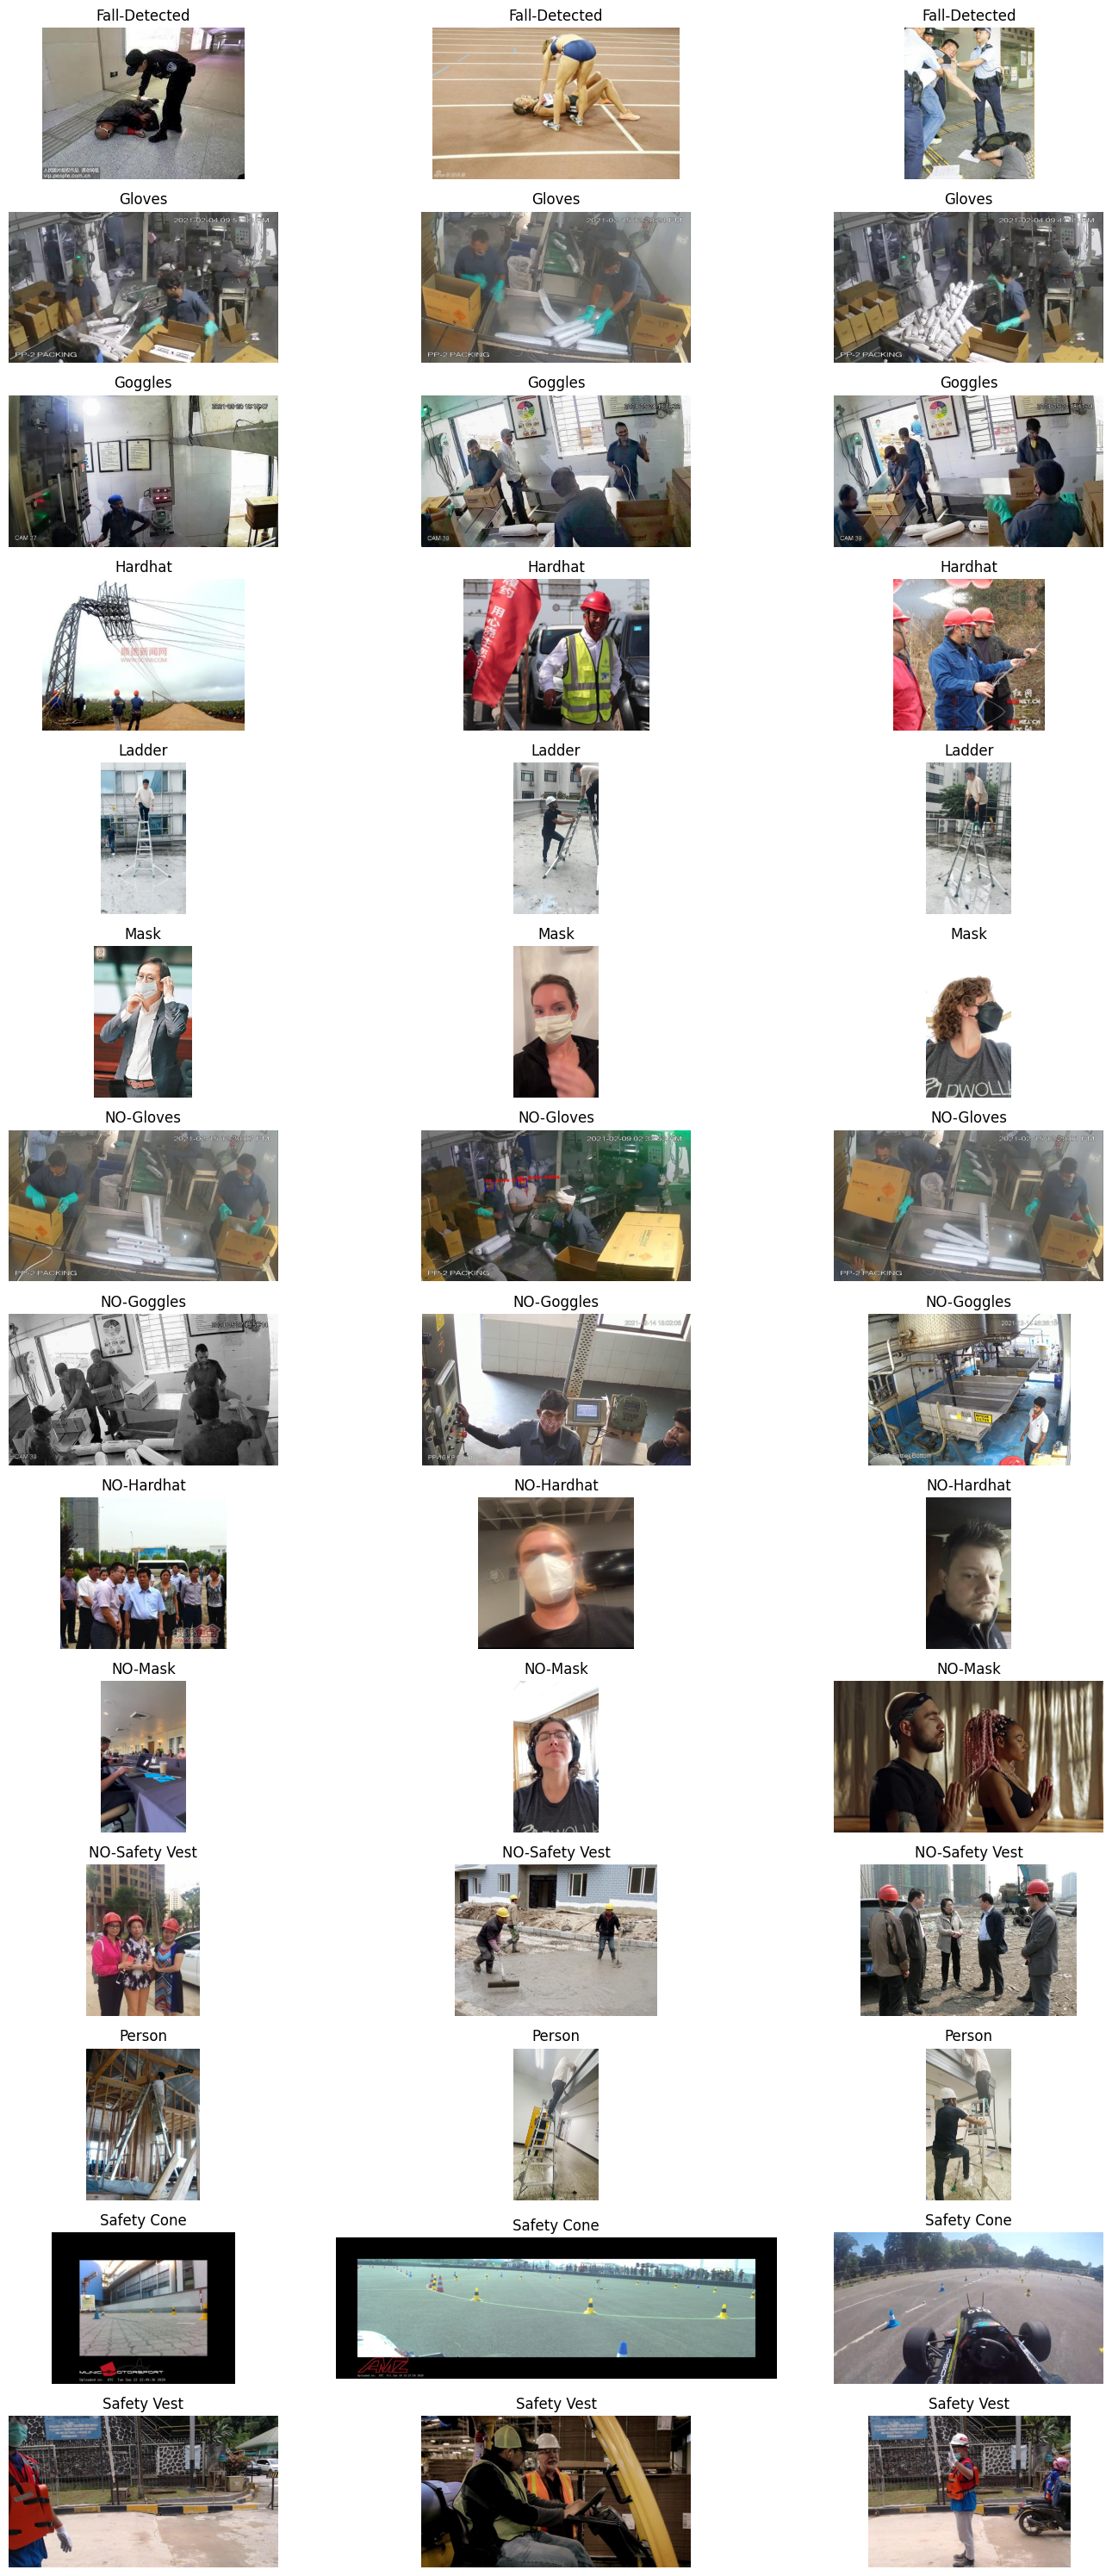

In [16]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------------------------
# CONFIG
# ------------------------------------------------

# Path to your dataset folder (where images are stored)
dataset_path = "/content/ppe/train"   # MODIFY THIS

# Your class names (same order as YOLO .txt labels)
class_names = {
    0: "Fall-Detected",
    1: "Gloves",
    2: "Goggles",
    3: "Hardhat",
    4: "Ladder",
    5: "Mask",
    6: "NO-Gloves",
    7: "NO-Goggles",
    8: "NO-Hardhat",
    9: "NO-Mask",
    10: "NO-Safety Vest",
    11: "Person",
    12: "Safety Cone",
    13: "Safety Vest"
}

# Number of sample images per class
num_samples = 3

# ------------------------------------------------
# HELPER FUNCTION
# ------------------------------------------------

def find_images_for_class(label_folder, target_class):
    """Find images that contain a target class in their YOLO label file."""
    matched_files = []
    for label_file in os.listdir(label_folder):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(label_folder, label_file)
        with open(label_path, "r") as f:
            labels = f.readlines()

        for line in labels:
            class_id = int(line.split()[0])
            if class_id == target_class:
                image_name = label_file.replace(".txt", ".jpg")
                matched_files.append(image_name)
                break

    return matched_files

# ------------------------------------------------
# GENERATE TABLE VIEW
# ------------------------------------------------

image_folder = dataset_path + "/images"  # MODIFY if your structure is different
label_folder = dataset_path + "/labels"

plt.figure(figsize=(15, 30))
plot_index = 1

for class_id, class_name in class_names.items():

    # Find matching images
    matched_images = find_images_for_class(label_folder, class_id)
    random.shuffle(matched_images)
    samples = matched_images[:num_samples]

    print(f"Class {class_id}: {class_name} → {len(samples)} samples")

    for img_name in samples:
        img_path = os.path.join(image_folder, img_name)

        plt.subplot(len(class_names), num_samples, plot_index)
        plot_index += 1

        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(class_name)
        else:
            plt.text(0.5, 0.5, 'Missing Image', ha='center')

plt.tight_layout()
plt.show()


## Drop of any unneccesary labels that are not required for this



The ‘mask’ class in the dataset represents an office-style hygiene mask and does not correspond to mining-approved respiratory PPE. This class is therefore excluded to maintain domain accuracy for WA mine-site operations.

In [17]:
import os

base_path = "/content/ppe"

# IDs to remove
remove_ids = [0, 1, 4, 5, 6, 9, 12]

def clean_labels(split):
    lbl_dir = os.path.join(base_path, split, "labels")

    for lbl_file in os.listdir(lbl_dir):
        if not lbl_file.endswith(".txt"):
            continue

        lbl_path = os.path.join(lbl_dir, lbl_file)

        with open(lbl_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])

            # Keep only classes NOT in remove list
            if class_id not in remove_ids:
                new_lines.append(line)

        # If ALL lines removed → delete label file (image becomes useless)
        if len(new_lines) == 0:
            os.remove(lbl_path)
        else:
            with open(lbl_path, "w") as f:
                f.writelines(new_lines)


# Clean labels for all splits
clean_labels("train")
clean_labels("valid")
clean_labels("test")


In [19]:
import pandas as pd

def build_df(split):
    img_dir = os.path.join(base_path, split, "images")
    lbl_dir = os.path.join(base_path, split, "labels")

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png"))])
    label_files = sorted([f for f in os.listdir(lbl_dir) if f.endswith(".txt")])

    data = []

    for img in image_files:
        base = img.rsplit(".", 1)[0]
        lbl = base + ".txt"

        if lbl in label_files:
            data.append({
                "image_path": os.path.join(img_dir, img),
                "label_path": os.path.join(lbl_dir, lbl)
            })

    df = pd.DataFrame(data)
    return df


df_train = build_df("train")
df_valid = build_df("valid")
df_test  = build_df("test")


In [20]:
print("TRAIN →", len(df_train))
print("VALID →", len(df_valid))
print("TEST  →", len(df_test))


TRAIN → 22466
VALID → 6464
TEST  → 3244


In [26]:
class_names = {
    2: "Goggles",
    3: "Hardhat",
    7: "NO-Goggles",
    8: "NO-Hardhat",
    10: "NO-Safety Vest",
    11: "Person",
    13: "Safety Vest"
}


In [27]:
def count_classes_from_df(df):
    class_counts = {}

    for lbl in df["label_path"]:
        with open(lbl, "r") as f:
            for line in f:
                cls = int(line.split()[0])
                class_counts[cls] = class_counts.get(cls, 0) + 1

    return class_counts


In [29]:
train_counts = count_classes_from_df(df_train)
valid_counts = count_classes_from_df(df_valid)
test_counts  = count_classes_from_df(df_test)


In [30]:
def print_split_counts(split_name, counts):
    print(f"--- {split_name.upper()} ---")
    for cls, count in sorted(counts.items()):
        print(f"Class {cls} ({class_names.get(cls, 'Unknown')}): {count}")
    print()

print_split_counts("train", train_counts)
print_split_counts("valid", valid_counts)
print_split_counts("test",  test_counts)


--- TRAIN ---
Class 2 (Goggles): 2959
Class 3 (Hardhat): 28996
Class 7 (NO-Goggles): 2817
Class 8 (NO-Hardhat): 9706
Class 9 (Unknown): 1577
Class 10 (NO-Safety Vest): 1436
Class 11 (Person): 1034
Class 13 (Safety Vest): 4499

--- VALID ---
Class 2 (Goggles): 827
Class 3 (Hardhat): 8952
Class 7 (NO-Goggles): 859
Class 8 (NO-Hardhat): 2222
Class 9 (Unknown): 505
Class 10 (NO-Safety Vest): 362
Class 11 (Person): 277
Class 13 (Safety Vest): 1287

--- TEST ---
Class 2 (Goggles): 402
Class 3 (Hardhat): 4480
Class 7 (NO-Goggles): 416
Class 8 (NO-Hardhat): 1038
Class 9 (Unknown): 218
Class 10 (NO-Safety Vest): 226
Class 11 (Person): 138
Class 13 (Safety Vest): 662

